In [14]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import timm
import torch
import numpy as np

from PIL import Image
from pathlib import Path
from dotenv import load_dotenv
from timm.data.loader import create_loader
from timm.data.dataset import ImageDataset
import torchvision.transforms as transforms

import os

from ViT.tooth_crop_dataset import ToothCropClassDataset
from utils.preprocess import rect_include_another, rotate_bounding_boxes, xyxy_reformat, xyxy2xywh
from utils.yolo import get_teeth_ROI
from utils.edge import tooth_isolation, bounding_teeth_on_origin, get_all_teeth

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

%matplotlib inline


# Model & env variable loaded

In [15]:
tooth_detect_model = torch.hub.load(r'.\YOLO', 'custom', path=r'.\YOLO\weights\8-bound.pt', source='local')
anomaly_detect_model = torch.hub.load(r'.\YOLO', 'custom', path=r'.\YOLO\weights\anomaly.pt', source='local')

# data_dir = '.' / Path(os.getenv('DATASET_DIR'))
data_dir = Path('..') / 'Datasets'


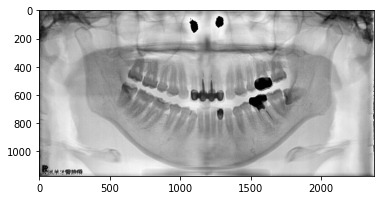

In [16]:
image_names = list(data_dir.glob('*.jpg'))

image_names = image_names[:20]
image_name = image_names[0]
filename = image_name.stem

im = cv2.imread(image_name)
# Only plt imshow need inverse process
plt.imshow(1 - im)
plt.show()


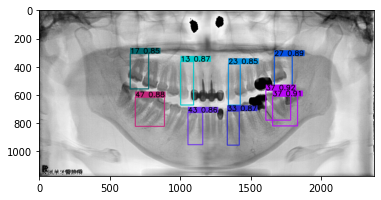

In [17]:
results = tooth_detect_model(image_names)
rendered_results = results.render()

plt.imshow(1 - rendered_results[0])
plt.show()


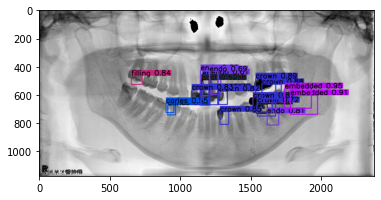

In [18]:
anomaly_results = anomaly_detect_model(image_names)
rendered_anomaly_results = anomaly_results.render()

plt.imshow(1 - rendered_anomaly_results[0])
plt.show()


In [19]:
results = tooth_detect_model(image_names)
teeth_region = get_all_teeth(results)
teeth_roi = get_teeth_ROI(results)

teeth_region


D:\Users\douli\anaconda3\envs\dentist-CV-main\lib\site-packages\yolov5\utils\plots.py:475: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyxy = torch.tensor(xyxy).view(-1, 4)


{'00008026': {'upper-left': {'crop_regions': {16: {'xyxy': tensor([194.,  96., 268., 353.]),
     'is_missing': False,
     'crop_image': array([[76, 78, 78, ..., 75, 76, 75],
            [77, 79, 78, ..., 75, 75, 74],
            [77, 79, 80, ..., 74, 74, 75],
            ...,
            [51, 50, 52, ..., 54, 52, 52],
            [51, 51, 52, ..., 53, 52, 51],
            [49, 51, 52, ..., 55, 55, 54]], dtype=uint8)},
    15: {'xyxy': tensor([268.,  96., 391., 353.]),
     'is_missing': False,
     'crop_image': array([[ 76,  76,  75, ..., 255, 255, 255],
            [ 75,  75,  75, ..., 255, 255, 255],
            [ 76,  76,  77, ..., 255, 255, 255],
            ...,
            [ 52,  53,  56, ...,  50,  52,  52],
            [ 52,  54,  57, ...,  52,  54,  54],
            [ 53,  54,  55, ...,  53,  54,  56]], dtype=uint8)}},
   'angle': 20},
  'upper-middle': {'crop_regions': {12: {'xyxy': tensor([ 29.,  74.,  94., 309.]),
     'is_missing': False,
     'crop_image': array([[59, 

# Save tooth crop image

In [20]:
temp_dir = '.' / Path(os.getenv('TEMP_DIR')) / 'crop_tooth_image'

missing_tooth = []
for file in temp_dir.glob('*.jpg'):
    os.remove(file)

for filename, region in teeth_region.items():
    for region_name, tooth_region in region.items():
        for tooth_number, data in tooth_region['crop_regions'].items():
            crop_image = data['crop_image']
            is_missing = data['is_missing']

            if is_missing:
                missing_tooth.append((filename, tooth_number))
                continue
            save_filepath = temp_dir / f'{filename} {region_name} {tooth_number}.jpg'

            temp_im = Image.fromarray(crop_image)
            temp_im.save(save_filepath)

# print(save_filepath)
missing_tooth


[]

# Model loading

In [21]:
model_dir = '.' / Path(os.getenv('ViT_MODEL_DIR'))
model_path = model_dir / 'classifier-6.pt'

vit_model = timm.create_model('vit_base_patch16_224', num_classes=6)
vit_model.load_state_dict(torch.load(model_path))
vit_model


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate=none)
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (ls2): 

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 16
num_workers = 0

# Preprocess
transform = transforms.Compose([
    transforms.ToTensor(),
    # (lambda image: padding_to_size(image, 224)),
    transforms.Resize(size=(224, 224)),
    transforms.Normalize(mean=0.5, std=0.5),
])
target_transform = transforms.Compose([
    (lambda y: torch.Tensor(y)),
])
dataset = ImageDataset(temp_dir, transform=transform)

if torch.cuda.is_available():
    dataloader = create_loader(dataset, (3, 224, 224), 4)
else:
    dataloader = create_loader(dataset, (3, 224, 224), 4, use_prefetcher=False)


In [23]:
size = len(dataloader.dataset)

vit_model.to(device)
vit_model.eval()

threshold = torch.Tensor([0.5, 0.85, 0.5, 0.5, 0.5, 0.5]).to(device)
pred_encodes = []
# target_labels = ['caries', 'endo', 'post', 'crown']
target_labels = ['R.R', 'caries', 'crown', 'endo', 'filling', 'post']
with torch.no_grad():
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        pred = vit_model(X)
        pred = torch.sigmoid(pred)
        pred_encode = pred > threshold
        pred_encodes.append(pred_encode.cpu().numpy())

pred_encodes = np.vstack(pred_encodes)
detected_list = [()] * len(pred_encodes)
for i, pred_encode in enumerate(pred_encodes):
    detected_list[i] = tuple((target_labels[j] for j, checker in enumerate(pred_encode) if checker))

detected_list


[('caries',),
 (),
 (),
 (),
 ('R.R',),
 (),
 (),
 ('caries',),
 ('caries', 'filling'),
 ('caries',),
 ('filling',),
 ('caries',),
 (),
 ('caries',),
 ('filling',),
 ('caries',),
 ('caries',),
 ('post',),
 (),
 ('endo',),
 ('caries',),
 ('R.R',),
 ('caries',),
 ()]

In [24]:
tooth_anomaly_dict = {anomaly_results.files[i][:-4]: {} for i in range(len(anomaly_results))}

for i, detected in enumerate(detected_list):
    current_filename, region_name, tooth_number = dataset.filename(i).split()
    tooth_number = int(tooth_number[:2])

    if tooth_number < 50:
        tooth_anomaly_dict[current_filename][tooth_number] = set(detected)

print(tooth_anomaly_dict)


{'00008026': {46: {'caries'}, 31: set(), 32: set(), 41: set(), 42: {'R.R'}, 34: set(), 13: {'caries'}, 17: {'caries', 'filling'}, 23: {'caries'}, 27: {'filling'}, 33: {'caries'}, 37: set(), 43: {'caries'}, 47: {'filling'}, 15: {'caries'}, 16: {'caries'}, 11: {'post'}, 12: set(), 21: {'endo'}, 22: {'caries'}, 24: {'caries'}, 25: set()}, '202011190311508061692_0210102A': {}}


# YOLO anomaly detect


In [25]:
iou_threshold = 0.5
region_wisdom_tooth_dict = {
    'upper-left': 18,
    'upper-right': 28,
    'lower-left': 48,
    'lower-right': 38,
}

for i in range(len(anomaly_results)):
    current_filename = anomaly_results.files[i][:-4]
    bounds = anomaly_results.xyxy[i]
    for j in range(len(bounds)):
        *xyxy, _, cls = bounds[j]
        xyxy = list(map(lambda t: t.cpu(), xyxy))

        cls = int(cls.item())
        name = anomaly_results.names[cls]
        if name in target_labels:
            continue

        # for x8 tooth
        if name in ['embedded', 'impacted']:
            min_distance = np.inf
            near_region = ''
            for region_data in teeth_roi['images'][current_filename]:
                region_xyxy = region_data['xyxy']
                region_xywh = xyxy2xywh(np.vstack([region_xyxy]))[0]

                xywh = xyxy2xywh(np.vstack([xyxy]))[0]

                distance = np.linalg.norm(xywh[:2] - region_xywh[:2])
                if distance < min_distance:
                    min_distance = distance
                    near_region = f'{region_data["flag"]}-{region_data["tooth_position"]}'
            if near_region in region_wisdom_tooth_dict:
                tooth_number = region_wisdom_tooth_dict[near_region]
                if tooth_number not in tooth_anomaly_dict[current_filename].keys():
                    tooth_anomaly_dict[current_filename][tooth_number] = {name}
                else:
                    tooth_anomaly_dict[current_filename][tooth_number].add(name)
            continue

        # for normal tooth
        located_regions = {}
        for region_data in teeth_roi['images'][current_filename]:
            region_xyxy = region_data['xyxy']
            if rect_include_another(region_xyxy, xyxy) > iou_threshold:
                located_regions[f'{region_data["flag"]}-{region_data["tooth_position"]}'] = region_data

        for located_region, region_data in located_regions.items():
            region_tooth_data = teeth_region[current_filename][located_region]
            tooth_angle = np.radians(region_tooth_data['angle'])

            offset = region_data['offset']
            region_image_shape = np.array(np.array(region_data['image'].shape)[[1, 0]])

            rotated_xyxy = [xyxy]
            rotated_xyxy = np.array(rotated_xyxy) - np.tile(offset, 2)
            rotated_xyxy = rotate_bounding_boxes(tooth_angle, region_image_shape, rotated_xyxy)
            rotated_xyxy = rotated_xyxy[0].astype(int)
            for tooth_number, tooth_data in region_tooth_data['crop_regions'].items():
                tooth_xyxy = tooth_data['xyxy']

                if rect_include_another(tooth_xyxy, rotated_xyxy) > iou_threshold:
                    # if tooth_number not in result[current_filename].keys():
                    #     result[current_filename][tooth_number] = {name}
                    # else:
                    tooth_anomaly_dict[current_filename][tooth_number].add(name)

for pair in missing_tooth:
    filename, tooth_number = pair
    tooth_anomaly_dict[filename][tooth_number] = {'missing'}

print(tooth_anomaly_dict)


{'00008026': {46: {'caries'}, 31: set(), 32: set(), 41: set(), 42: {'R.R'}, 34: set(), 13: {'caries'}, 17: {'caries', 'filling'}, 23: {'caries'}, 27: {'filling'}, 33: {'caries'}, 37: set(), 43: {'caries'}, 47: {'filling'}, 15: {'caries'}, 16: {'caries'}, 11: {'post'}, 12: set(), 21: {'endo'}, 22: {'caries'}, 24: {'caries'}, 25: set(), 28: {'embedded'}}, '202011190311508061692_0210102A': {}}


In [26]:
tooth_anomaly_dict['202011190311508061692_0210102A.jpg']


KeyError: '202011190311508061692_0210102A.jpg'